In [284]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## 1.

In [285]:
def create_gaussian_kernel(size, sigma, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    kernel_1D = np.exp(-(kernel_1D**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Image")
        plt.show()

    return kernel_2D

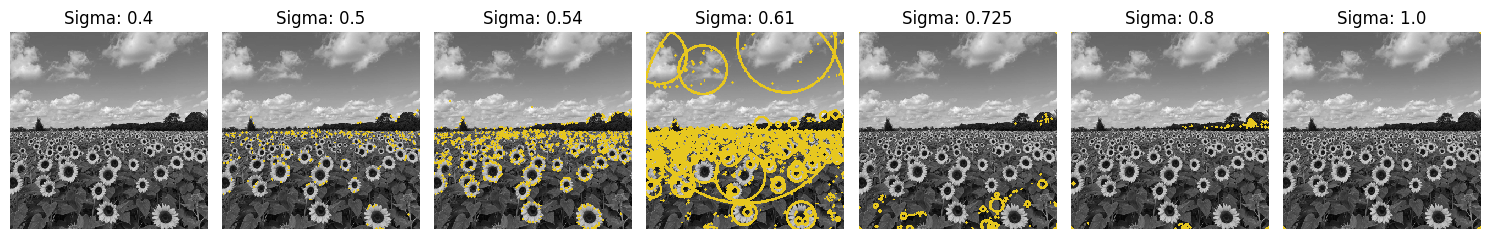

Sigma: 0.4 - Number of Blobs: 0 - Larger Circle Radius: 0, Center: (0, 0)
Sigma: 0.5 - Number of Blobs: 220 - Larger Circle Radius: 1, Center: (311, 208)
Sigma: 0.54 - Number of Blobs: 773 - Larger Circle Radius: 2, Center: (12, 237)
Sigma: 0.61 - Number of Blobs: 1040 - Larger Circle Radius: 185, Center: (179, 128)
Sigma: 0.725 - Number of Blobs: 85 - Larger Circle Radius: 253, Center: (179, 179)
Sigma: 0.8 - Number of Blobs: 51 - Larger Circle Radius: 253, Center: (179, 179)
Sigma: 1.0 - Number of Blobs: 1 - Larger Circle Radius: 253, Center: (179, 179)


In [286]:
# Load the image
img = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
assert img is not None, 'Image not found'

# List of sigma values to iterate over
sigma_values = [0.4, 0.5, 0.54, 0.61, 0.725, 0.8, 1.0]

num_sigma = len(sigma_values)
fig, axs = plt.subplots(1, num_sigma, figsize=(15, 5))

Blobs = []
larger_circle_radius = []
larger_circle_center = []

for idx, sigma in enumerate(sigma_values):

    gaussian_kernel = create_gaussian_kernel(5, sigma, verbose=False)

    # Find the Laplace of the Gaussian kernel
    laplace_of_gaussian_kernel = cv.Laplacian(gaussian_kernel, cv.CV_64F) * sigma**2

    # Apply the Laplace of Gaussian kernel to the image
    laplace_of_gaussian_img = cv.filter2D(img, -1, laplace_of_gaussian_kernel)

    # Thresholding
    threshold_value = 81
    _, binary_img = cv.threshold(np.abs(laplace_of_gaussian_img), threshold_value, 255, cv.THRESH_BINARY)

    # Find Contours
    contours, _ = cv.findContours(binary_img.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw Circles on the original image
    original_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    Blobs.append(len(contours))
    largest_radius = 0
    largest_center = (0, 0)
    
    for contour in contours:
        # Calculate the center and radius of the blob
        ((x, y), radius) = cv.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Check if this circle is the largest one
        if radius > largest_radius:
            largest_radius = radius
            largest_center = center
        
        # Draw the circle
        cv.circle(original_img, center, radius, (231, 199, 31), 3)  #thickness = 3
        
    larger_circle_radius.append(largest_radius)
    larger_circle_center.append(largest_center)
        

    axs[idx].imshow(original_img, interpolation='none', cmap='gray')
    axs[idx].set_title(f"Sigma: {sigma}")
    axs[idx].axis('off')
    

plt.tight_layout()
plt.show()

# Print the number of blobs detected for each sigma value
for idx, sigma in enumerate(sigma_values):
    print(f"Sigma: {sigma} - Number of Blobs: {Blobs[idx]} - Larger Circle Radius: {larger_circle_radius[idx]}, Center: {larger_circle_center[idx]}")


## 2.

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
from scipy import optimize
import random
from matplotlib.patches import Circle

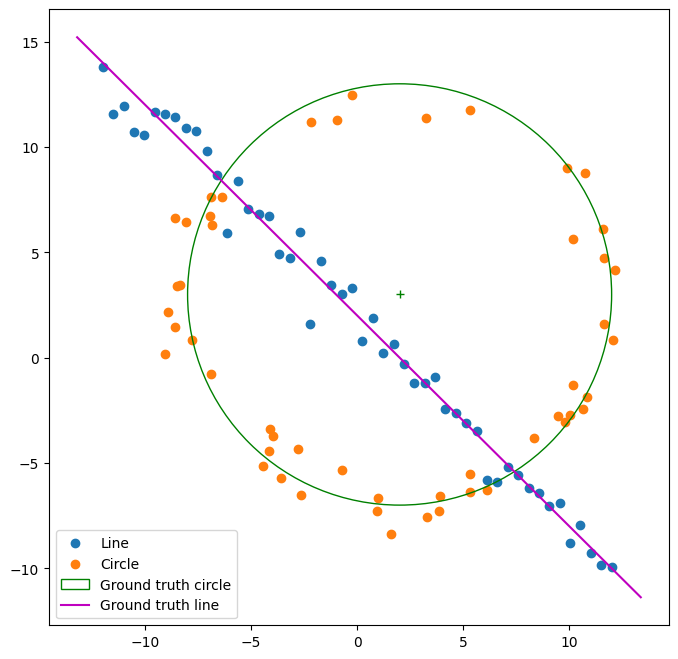

In [2]:
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


In [3]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def line_eq(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a*x1 + b*y1
    assert abs(a*x2 + b*y2 - d) < 1e-8

    # Normalize coefficients
    norm = (a**2 + b**2)**0.5
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    
    # The circumcenter is equidistant from all three points
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x1 + x3) / 2, (y1 + y3) / 2

    s1 = -(x2 - x1) / (y2 - y1)
    s2 = -(x3 - x1) / (y3 - y1)

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1) / (s1 - s2)
    cy = s1 * cx + c1
    assert abs(s2 * cx + c2 - cy) < 1e-8

    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - dist((cx, cy), p1)) < 1e-8
    return cx, cy, r


In [4]:
# Squared error calculation for line and circle
def tls_error_line(params, *args):
    # Calculate the error for points specified by indices;
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d) ** 2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r) ** 2)
    return error


In [5]:
def consensus_line(params, thres, X):  # Determines inliers for each point
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):  # Determines inliers for each point
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r)  # Compute radial error
    return np.where(errors < thres)

def constraint(params):
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

constraint_dict = {'type': 'eq', 'fun': constraint}

def least_squares_line_fit(indices, initial, X): 
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res


In [6]:
# Fitting the line
iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.0  # Error threshold for identifying inliers
d = 0.4 * N  # Minimum number of inliers required for a reliable fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: Number of inliers = {len(inliers)}')

    if len(inliers) >= d:  
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best fitted line = {best_fitted_line}, Number of inliers = {len(line_inliers)}, Best error = {best_error}')


Iteration 0: Number of inliers = 7
Iteration 1: Number of inliers = 27
Iteration 2: Number of inliers = 9
Iteration 3: Number of inliers = 13
Iteration 4: Number of inliers = 7
Iteration 5: Number of inliers = 5
Iteration 6: Number of inliers = 21
Iteration 7: Number of inliers = 9
Iteration 8: Number of inliers = 5
Iteration 9: Number of inliers = 47
[0.70981477 0.70438838 1.43422976] 9.990607009740827
Iteration 10: Number of inliers = 6
Iteration 11: Number of inliers = 5
Iteration 12: Number of inliers = 11
Iteration 13: Number of inliers = 6
Iteration 14: Number of inliers = 8
Iteration 15: Number of inliers = 15
Iteration 16: Number of inliers = 10
Iteration 17: Number of inliers = 16
Iteration 18: Number of inliers = 14
Iteration 19: Number of inliers = 20
Iteration 20: Number of inliers = 13
Iteration 21: Number of inliers = 14
Iteration 22: Number of inliers = 31
Iteration 23: Number of inliers = 36
Iteration 24: Number of inliers = 11
Iteration 25: Number of inliers = 6
Iterat

In [7]:
remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

iters = 100
min_points = 3  # Three points are needed to define a circle

thres = 1.2  # Error threshold for determining inliers
d = 0.4 * N  # Minimum number of inliers required for a reliable fit

best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle_eq(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: Number of inliers = {len(inliers)}')

    if len(inliers) >= d: 
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]

print(f'Best fitted circle = {best_fitted_circle}, Number of inliers = {len(circ_inliers)}, Best error = {best_error}')


Iteration 0: Number of inliers = 6
Iteration 1: Number of inliers = 16
Iteration 2: Number of inliers = 6
Iteration 3: Number of inliers = 11
Iteration 4: Number of inliers = 23
Iteration 5: Number of inliers = 38
Iteration 6: Number of inliers = 10
Iteration 7: Number of inliers = 22
Iteration 8: Number of inliers = 40
[ 1.71261361  2.90023828 10.11218503] 9.597477591343733
Iteration 9: Number of inliers = 10
Iteration 10: Number of inliers = 8
Iteration 11: Number of inliers = 10
Iteration 12: Number of inliers = 14
Iteration 13: Number of inliers = 7
Iteration 14: Number of inliers = 12
Iteration 15: Number of inliers = 17
Iteration 16: Number of inliers = 18
Iteration 17: Number of inliers = 11
Iteration 18: Number of inliers = 8
Iteration 19: Number of inliers = 10
Iteration 20: Number of inliers = 41
[2.20659785 2.86615882 9.68898621] 11.196312144963366
Iteration 21: Number of inliers = 29
Iteration 22: Number of inliers = 9
Iteration 23: Number of inliers = 31
Iteration 24: Numb

In [8]:
# Plotting
def plot_all(separate=True):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='limegreen', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='limegreen')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax


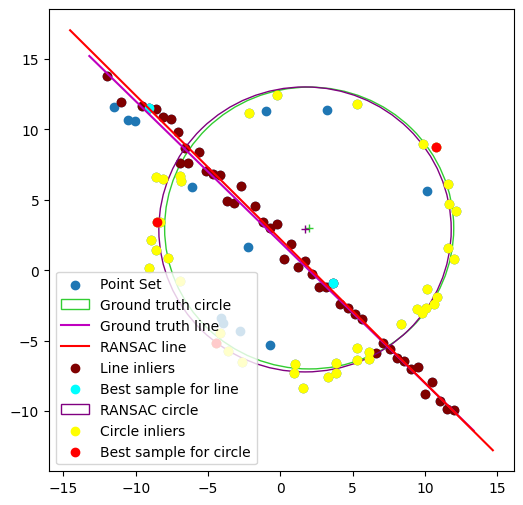

In [9]:
ax = plot_all(False)

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A * x_) / B
plt.plot(x_, y_, color='r', label='RANSAC line')
ax.scatter(X[indices, 0], X[indices, 1], color='maroon', label="Line inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color='cyan', label="Best sample for line")

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='purple', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='purple')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color='yellow', label="Circle inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color='red', label="Best sample for circle")

plt.legend()


# 3.

In [2]:
import cv2 as cv
import numpy as np

# Set the number of points to collect
num_points = 4
point_count = 0
image_points = np.empty((num_points, 2))

# Load the architectural image and the flag image
Main_img = cv.imread('images/lotus-tower.png', cv.IMREAD_COLOR)
Wrapping_img = cv.imread('images/entc.png', cv.IMREAD_COLOR)

# Mouse event handler function
def mark_point(event, x, y, flags, parameters):
    global point_count
    points = parameters[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(parameters[1], (x, y), 5, (255, 0, 0), -1)
        points[point_count] = (x, y)
        point_count += 1

# Create a window and set the mouse callback
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
params = [image_points, Main_img]
cv.setMouseCallback('Image', mark_point, params)

# Loop to display the image and collect points
while True:
    cv.imshow('Image', Main_img)
    if point_count == num_points:
        break
    if cv.waitKey(20) & 0xFF == 27:  # Escape key to exit
        break

# Define corresponding points on the flag image, forming a rectangle
flag_coordinates = np.array([[0, 0], 
                             [Wrapping_img.shape[1], 0], 
                             [Wrapping_img.shape[1], Wrapping_img.shape[0]], 
                             [0, Wrapping_img.shape[0]]], 
                             dtype=np.float32)

# Calculate the homography matrix
homography, _ = cv.findHomography(flag_coordinates, image_points)

# Apply the homography to warp the flag image onto the architectural image
warped_flag = cv.warpPerspective(Wrapping_img, homography, (Main_img.shape[1], Main_img.shape[0]))

# Blend the architectural image with the warped flag image
result_image = cv.addWeighted(Main_img, 1, warped_flag, 0.7, 0)

cv.imshow('Superimposed Image', result_image)
cv.waitKey(0)
cv.destroyAllWindows()


# Question 4

In [405]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline
import skimage as transform

In [406]:
def SIFT_features(img1, img2, Display=False):
    
    gray_img1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    gray_img2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)

    sift_detector = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

    # Detect and compute keypoints and descriptors in both images
    keypoints1, descriptors1 = sift_detector.detectAndCompute(gray_img1, None)
    keypoints2, descriptors2 = sift_detector.detectAndCompute(gray_img2, None)

    matcher = cv.BFMatcher()

    knn_matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    valid_matches = []
    for m, n in knn_matches:
        if m.distance < 0.75 * n.distance:
            valid_matches.append(m)

    if Display:
        plt.figure(figsize=(10, 5))

        # Show keypoints detected in the first image
        plt.subplot(1, 2, 1)
        img1_keypoints = cv.drawKeypoints(gray_img1, keypoints1, None)
        plt.imshow(img1_keypoints)
        plt.title("Keypoints in Image 1")
        plt.axis('off')

        # Show keypoints detected in the second image
        plt.subplot(1, 2, 2)
        img2_keypoints = cv.drawKeypoints(gray_img2, keypoints2, None)
        plt.imshow(img2_keypoints)
        plt.title("Keypoints in Image 2")
        plt.axis('off')

        # Display the matched features between the two images
        plt.figure(figsize=(10, 5))
        matched_img = cv.drawMatches(gray_img1, keypoints1, gray_img2, keypoints2, valid_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(matched_img)
        plt.title("Feature Matches Between Image 1 and 2")
        plt.axis('off')
    
    return valid_matches, keypoints1, keypoints2

In [407]:
def get_inliers(src_points, dst_points, transformation, threshold):
    transformed_points = transformation(src_points)
    distances = np.linalg.norm(transformed_points - dst_points, axis=1)
    return np.where(distances < threshold)[0]


In [408]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)


        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

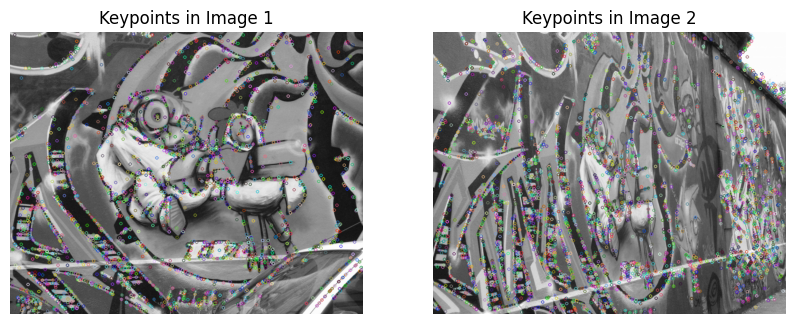

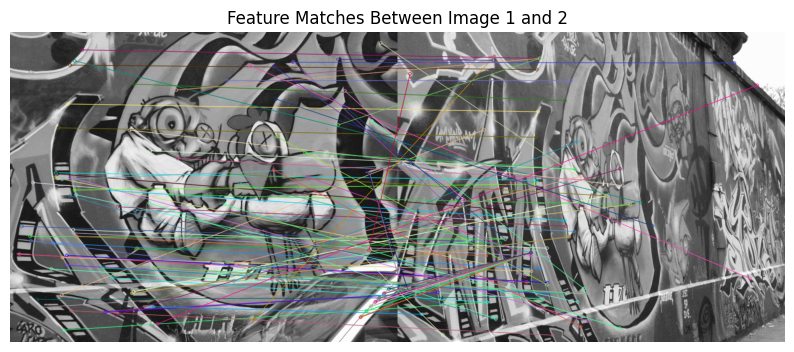

In [409]:
img1 = cv.imread("images/graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("images/graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

features = SIFT_features(img1, img5, Display = True)

Best no. of inliers = 734
Best no. of inliers = 544
Best no. of inliers = 695
Best no. of inliers = 493


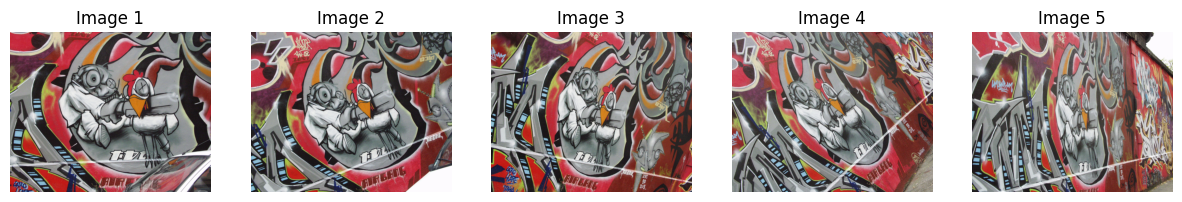

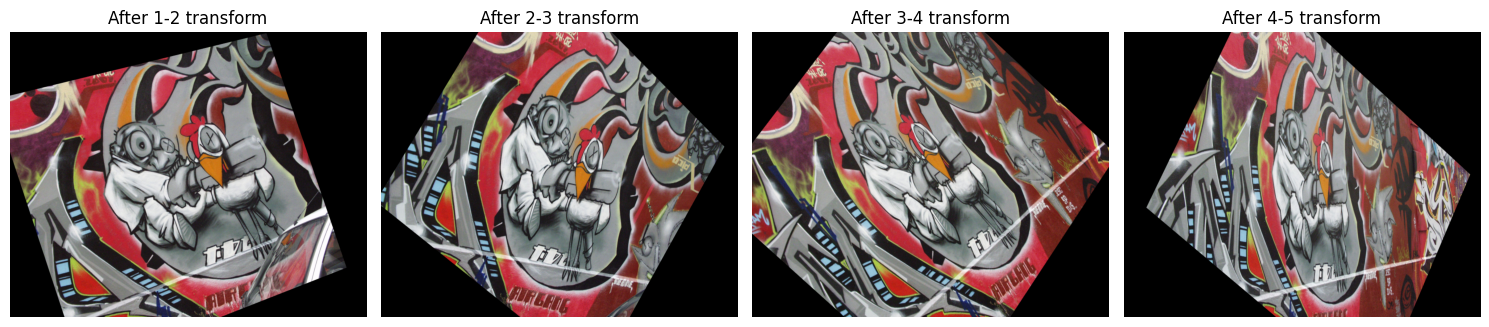

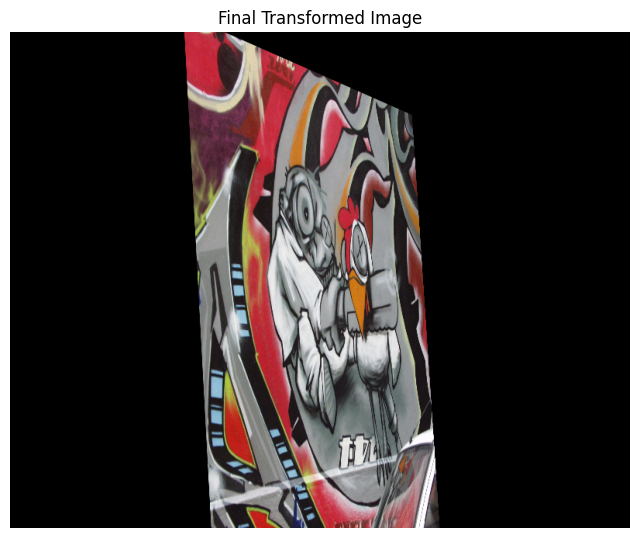

In [410]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import transform

np.random.seed(62)
pad = 100

# Load and display the images
images = []
plt.figure(figsize=(15, 10))
for i in range(1, 6):
    img = cv.imread(f"images/graf/img{i}.ppm")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis('off')

final_transform = transform.ProjectiveTransform(np.identity(3))


plt.figure(figsize=(15, 10))
for i in range(1, 5):
    img1, img2 = images[i-1], images[i]
    
    good_matches, keypoints1, keypoints5 = SIFT_features(img1, img2)
    tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)
    
    final_transformed_image = transform.warp(img1, tform.inverse)
    
    final_transform = final_transform + tform
    
    plt.subplot(1, 4, i)
    plt.imshow(final_transformed_image)
    plt.title(f"After {i}-{i+1} transform")
    plt.axis('off')

plt.tight_layout()


final_transformed_image = transform.warp(images[0], final_transform.inverse)

plt.figure(figsize=(8, 8))
plt.imshow(final_transformed_image)
plt.title("Final Transformed Image")
plt.axis('off')
plt.show()

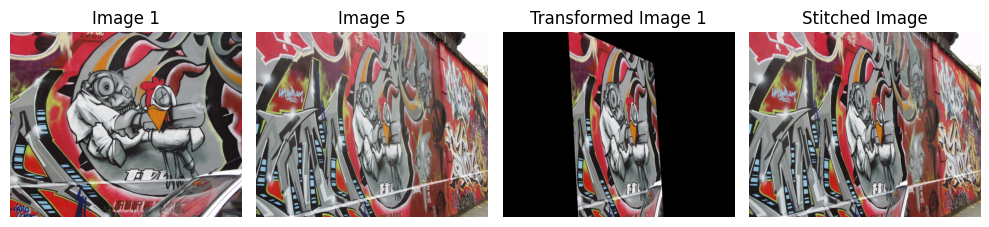

In [411]:
# Apply the final transformation to the first image and convert the pixel values to uint8 format
final_warped_image = transform.warp(image_set[0], cumulative_transform.inverse)
final_warped_image = (final_warped_image * 255).astype(np.uint8)

mask = (final_warped_image == 0)

stitched_result = mask * image_set[4] + final_warped_image

plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(image_set[0])
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_set[4])
plt.title("Image 5")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_warped_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_result)
plt.title("Stitched Image")
plt.axis('off')

plt.tight_layout()


In [412]:
actual_tform = np.array([[   6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
 [  2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
 [  4.9212545e-04,  -3.6542424e-05,   1.0000000e+00]])

print("Computed Homography")
print(final_transform.params)
print()
print("Actual Homography")
print(actual_tform)
print()

print("Sum of squared errors:", np.sum(np.square(actual_tform - final_transform.params)))

Computed Homography
[[ 6.11404459e-01  5.03189502e-02  2.21391678e+02]
 [ 2.11980223e-01  1.14096503e+00 -2.14952739e+01]
 [ 4.74861344e-04 -5.18621014e-05  9.90604809e-01]]

Actual Homography
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of squared errors: 17.280918220859423
